In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
import re
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import torchvision.models as models
import torchvision.transforms as transforms

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
sns.set_style("whitegrid")
from bs4 import BeautifulSoup

In [2]:
cwd=os.getcwd()
xml_files_path=cwd+'/data/xml_reports'

xml_files=os.listdir(xml_files_path)
xml_files.sort()

xml_files=[os.path.join(xml_files_path,xml_file) for xml_file in xml_files]



In [3]:
with open(xml_files[0],'r') as f:
    xml=f.read()
    print(xml)

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

In [4]:
path_for_images=cwd+'/data/images/images_normalized'

images=os.listdir(path_for_images)

images.sort()

all_images=[os.path.join(path_for_images,image) for image in images]

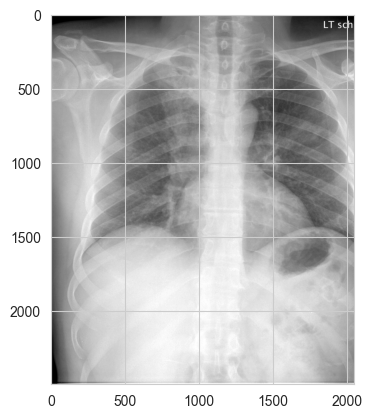

In [5]:
#display X-Ray Image 
img = Image.open(all_images[0])
plt.imshow(img, cmap='gray')



In [6]:
#checking the total number of xml reports files and images 
len(all_images),len(xml_files)

(7470, 3955)

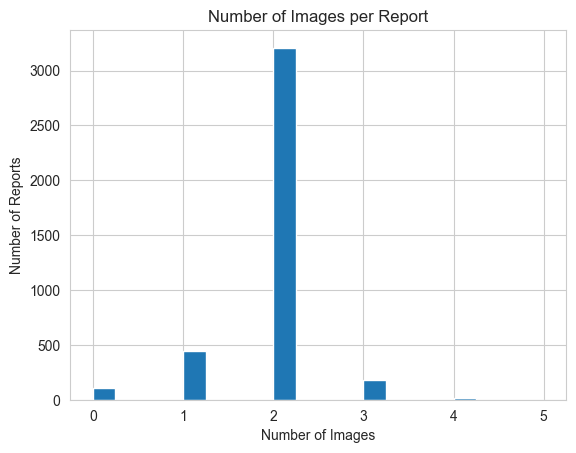

In [7]:
#number of images associated with each xml report
images_per_report=[]
for xml_file in xml_files:
    with open(xml_file,'r') as f:
        xml=f.read()
        regex=r"parentImage id=*"
        k=re.findall(regex,xml)
        images_per_report.append(len(k)) 

#plotting the number of images per report
plt.hist(images_per_report,bins=20)
plt.xlabel('Number of Images')
plt.ylabel('Number of Reports')
plt.title('Number of Images per Report')
plt.show()


In [8]:
#maximum number of images per report
print("maximum no of images per report: ",max(images_per_report))
#minimum number of images per report
print("Minimum no of images per report: ",min(images_per_report))

maximum no of images per report:  5
Minimum no of images per report:  0


In [9]:
#applying groupby to get the number of reports with the same number of images
df=pd.DataFrame(images_per_report,columns=['images'])
df['count']=1
df=df.groupby('images').count()
df.reset_index(inplace=True)
print(df.head())


   images  count
0       0    104
1       1    446
2       2   3208
3       3    181
4       4     15


In [10]:
columns = ["image_name","image_caption","comparison", "indication", "findings", "impression"]
df = pd.DataFrame(columns=columns)
data_list = []

# loop through the xml files and parse the relevant information and assign it to the dataframe
for xml_file in xml_files:
    with open(xml_file, 'r') as f:
        xml = f.read()
        
        # Parse the XML data
        root = ET.fromstring(xml)     
        # Find the Abstract element
        abstract = root.find('.//Abstract')

            # Initialize variables to store the texts
        impression = None
        findings = None
        comparison = None
        indication = None
        image_name=""
        image_caption=None
        
            # Iterate over AbstractText elements
        for abstract_text in abstract.findall('AbstractText'):
            label = abstract_text.get('Label')
            text = abstract_text.text
            if label == 'IMPRESSION':
                    impression = text
            elif label == 'FINDINGS':
                    findings = text
            elif label == 'COMPARISON':
                    comparison = text
            elif label == 'INDICATION':
                    indication = text
    
    
    
          
        # Iterate over parentImage elements
        
        parentImages=root.findall('.//parentImage')
    for parentImage in parentImages:
    
        #remove first 5 characters from the image name
        img=parentImage.get('id')
        #if the image has CXR1_ in the name then remove it
        if img[:5]=='CXR1_':
            img=img[5:]
        elif img[:3]=='CXR':
            img=img[3:]
        #concat image extension to the image name     
        image_name+=img+ '.dcm.png'+','
        image_caption=parentImage.find('caption').text

            
    #trim the last comma from the image_name
    
    image_name=image_name[:-1]
        
    data_list.append({
            "image_name": image_name,
            "image_caption": image_caption,
            "comparison": comparison,
            "indication": indication,
            "findings": findings,
            "impression": impression
        })
   





In [11]:
print(len(data_list))

3955


In [12]:
df=pd.concat([df,pd.DataFrame(data_list)])

In [13]:
#replace comparison None. with empty None
df['comparison'].replace('None.', 'None', inplace=True)

In [14]:
df.head()

image_name   
0      1_IM-0001-3001.dcm.png,1_IM-0001-4001.dcm.png  \
1    10_IM-0002-1001.dcm.png,10_IM-0002-2001.dcm.png   
2  100_IM-0002-1001.dcm.png,100_IM-0002-2001.dcm.png   
3  1000_IM-0003-1001.dcm.png,1000_IM-0003-2001.dc...   
4  1001_IM-0004-1001.dcm.png,1001_IM-0004-1002.dc...   

                                   image_caption   
0                      Xray Chest PA and Lateral  \
1             PA and lateral chest x-XXXX XXXX.    
2   CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM    
3             PA and lateral chest x-XXXX XXXX.    
4    CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM   

                              comparison   
0                                   None  \
1                Chest radiographs XXXX.   
2                                   None   
3  XXXX PA and lateral chest radiographs   
4                                   None   

                                          indication   
0                                   Positive TB test  \
1                    XXXX-year-old male, chest pain.   
2                                               None   
3                          XXXX-year-old male, XXXX.   
4  dyspnea, subjective fevers, arthritis, immigra...   

                                            findings   
0  The cardiac silhouette and mediastinum size ar...  \
1  The cardiomediastinal silhouette is within nor...   
2  Both lungs are clear and expanded. Heart and m...   
3  There is XXXX increased opacity within the rig...   
4  Interstitial markings are diffusely prominent ...   

                                          impression  
0                               Normal chest x-XXXX.  
1                  No acute cardiopulmonary process.  
2                                 No active disease.  
3  1. Increased opacity in the right upper lobe w...  
4  Diffuse fibrosis. No visible focal acute disease.

In [15]:
#displaying specific image from data frame 
full_path_image=os.path.join(path_for_images,df['image_name'][0].split(',')[1])

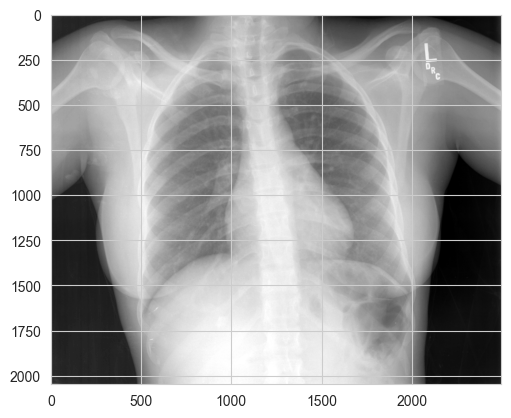

In [16]:
img = Image.open(full_path_image)
plt.imshow(img, cmap='gray')

In [17]:
df.shape

(3955, 6)

In [18]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [19]:
def preprocess_text(data): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  preprocessed = []

  for sentence in tqdm(data.values):

    sentence = BeautifulSoup(sentence, 'lxml').get_text()

    regex = r"\d." 
    sentence = re.sub(regex,"",sentence) #removing all values like "1." and "2." etc

    regex = r"X+"
    sentence = re.sub(regex,"",sentence) #removing words like XXXX

    regex = r"[^.a-zA-Z]" 
    sentence = re.sub(regex," ",sentence) #removing all special characters except for full stop

    regex = r"http\S+"
    sentence = re.sub(regex,"", sentence)
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", sentence)
    sentence = re.sub('&', 'and',sentence)
    sentence = re.sub('@', 'at',sentence)
    sentence = re.sub('0', 'zero',sentence)
    sentence = re.sub('1', 'one',sentence)
    sentence = re.sub('2', 'two',sentence)
    sentence = re.sub('3', 'three',sentence)
    sentence = re.sub('4', 'four',sentence)
    sentence = re.sub('5', 'five',sentence)
    sentence = re.sub('6', 'six',sentence)
    sentence = re.sub('7', 'seven',sentence)
    sentence = re.sub('8', 'eight',sentence)
    sentence = re.sub('9', 'nine',sentence)
    sentence = re.sub('year old', "", sentence)#Occur multiple times in Indication feature but not necessary     
    sentence = re.sub('yearold', "", sentence)
    sentence = decontracted(sentence) #perform decontraction
    sentence = sentence.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
    sentence = " ".join(sentence.split()) #removes unwanted spaces
    if sentence=="": #if the resulting sentence is an empty string return null value
      sentence = np.nan
    preprocessed.append(sentence)
  return preprocessed

In [20]:
#Preprocessing of text features
df['image_caption'] = preprocess_text(df['image_caption'].fillna(''))    
df['comparison'] = preprocess_text(df['comparison'].fillna(''))  
df['indication'] = preprocess_text(df['indication'].fillna(''))  
df['findings'] = preprocess_text(df['findings'].fillna(''))  
df['impression'] = preprocess_text(df['impression'].fillna(''))  

  0%|          | 0/3955 [00:00<?, ?it/s]

100%|██████████| 3955/3955 [00:01<00:00, 3322.88it/s]


In [21]:
#Check for Null values in Text columns
NaN = df.isnull().sum()
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in comparison columns -",NaN[2])
print("Total Nan Values in Indication columns -",NaN[3])
print("Total Nan Values in findings columns   -",NaN[4])
print("Total Nan Values in Impression columns -",NaN[5])

Total Nan Values in caption columns - 106
Total Nan Values in comparison columns - 1451
Total Nan Values in Indication columns - 313
Total Nan Values in findings columns   - 531
Total Nan Values in Impression columns - 34


In [22]:
#Replacing the nan values
df['image_caption'] = df['image_caption'].fillna('Unknown')
df['comparison'] = df['comparison'].fillna('No Comparison')
df['indication'] = df['indication'].fillna('No Indication')
df['findings'] = df['findings'].fillna('No Findings')
df['impression'] = df['impression'].fillna('No Impression')

In [23]:
df.head()

image_name   
0      1_IM-0001-3001.dcm.png,1_IM-0001-4001.dcm.png  \
1    10_IM-0002-1001.dcm.png,10_IM-0002-2001.dcm.png   
2  100_IM-0002-1001.dcm.png,100_IM-0002-2001.dcm.png   
3  1000_IM-0003-1001.dcm.png,1000_IM-0003-2001.dc...   
4  1001_IM-0004-1001.dcm.png,1001_IM-0004-1002.dc...   

              image_caption                        comparison   
0  ray chest pa and lateral                              none  \
1    pa and lateral chest x                 chest radiographs   
2  chest frontal lateral pm                              none   
3    pa and lateral chest x  pa and lateral chest radiographs   
4  chest frontal lateral pm                              none   

                                          indication   
0                                   positive tb test  \
1                                    male chest pain   
2                                      No Indication   
3                                               male   
4  dyspnea subjective fevers arthritis immigrant ...   

                                            findings   
0  the cardiac silhouette and mediastinum size ar...  \
1  the cardiomediastinal silhouette is within nor...   
2  both lungs are clear and expanded heart and me...   
3  there is increased opacity within the right up...   
4  interstitial markings are diffusely prominent ...   

                                          impression  
0                                     normal chest x  
1                   no acute cardiopulmonary process  
2                                  no active disease  
3  increased opacity in the right upper lobe with...  
4    diffuse fibrosis no visible focal acute disease

In [24]:
df.replace("", float("NaN"), inplace=True)

In [25]:
print(df.isnull().sum()*100/df.shape[0] )


image_name       2.629583
image_caption    0.000000
comparison       0.000000
indication       0.000000
findings         0.000000
impression       0.000000
dtype: float64


In [26]:
df.dropna(subset = ["image_name"], inplace=True)
df.shape

(3851, 6)

In [27]:
df['image_count'] = df['image_name'].astype(str).str.split(',').apply(len)

In [28]:
#Adding word count feature for indication, findings and impression
df['indication_count'] = df['indication'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
df['findings_count'] = df['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
df['impression_count'] = df['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
df.head()

image_name   
0      1_IM-0001-3001.dcm.png,1_IM-0001-4001.dcm.png  \
1    10_IM-0002-1001.dcm.png,10_IM-0002-2001.dcm.png   
2  100_IM-0002-1001.dcm.png,100_IM-0002-2001.dcm.png   
3  1000_IM-0003-1001.dcm.png,1000_IM-0003-2001.dc...   
4  1001_IM-0004-1001.dcm.png,1001_IM-0004-1002.dc...   

              image_caption                        comparison   
0  ray chest pa and lateral                              none  \
1    pa and lateral chest x                 chest radiographs   
2  chest frontal lateral pm                              none   
3    pa and lateral chest x  pa and lateral chest radiographs   
4  chest frontal lateral pm                              none   

                                          indication   
0                                   positive tb test  \
1                                    male chest pain   
2                                      No Indication   
3                                               male   
4  dyspnea subjective fevers arthritis immigrant ...   

                                            findings   
0  the cardiac silhouette and mediastinum size ar...  \
1  the cardiomediastinal silhouette is within nor...   
2  both lungs are clear and expanded heart and me...   
3  there is increased opacity within the right up...   
4  interstitial markings are diffusely prominent ...   

                                          impression  image_count   
0                                     normal chest x            2  \
1                   no acute cardiopulmonary process            2   
2                                  no active disease            2   
3  increased opacity in the right upper lobe with...            3   
4    diffuse fibrosis no visible focal acute disease            2   

   indication_count  findings_count  impression_count  
0                 3              33                 3  
1                 3              38                 4  
2                 2              10                 3  
3                 1              52                36  
4                 7              14                 7

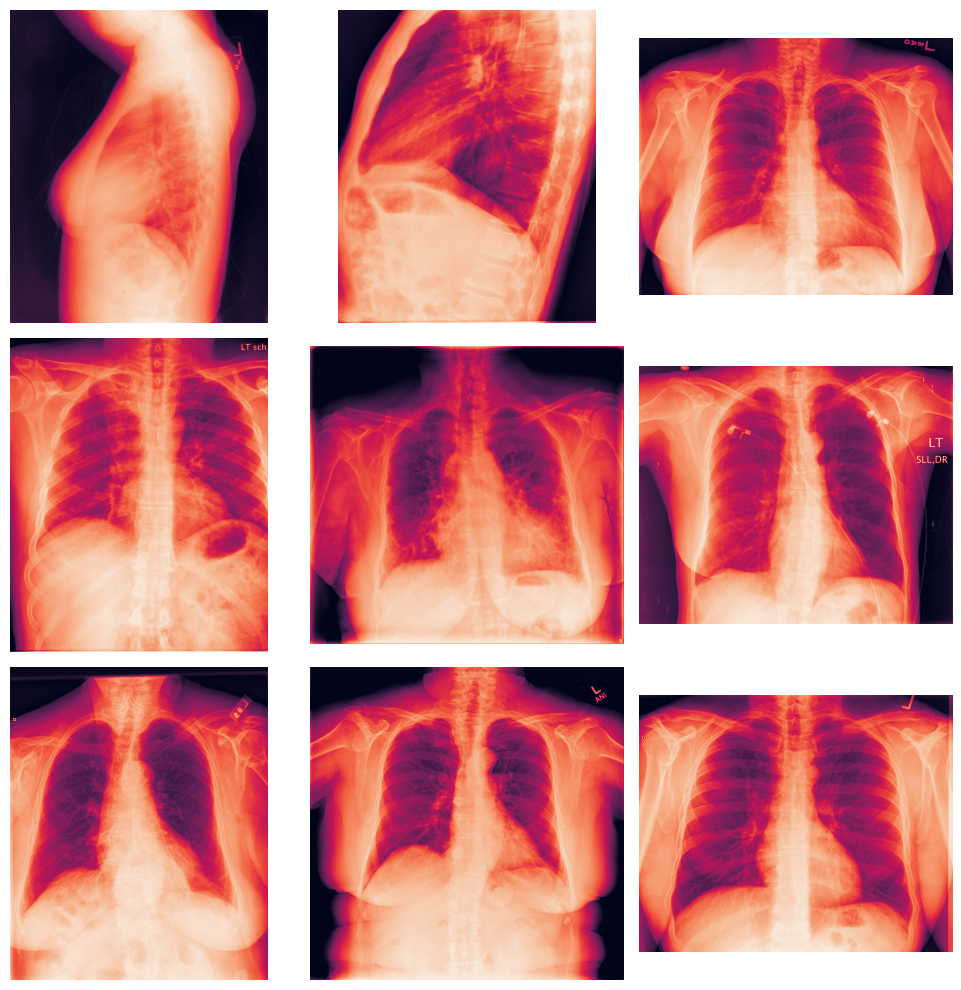

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    img_path = None 
    if ',' in df['image_name'][i]:
        img_name = df['image_name'][i].split(',')[0]
    else:
        img_name = df['image_name'][i]
    
    img_path = os.path.join("./data/images/images_normalized/", img_name)
    
    image = mpimg.imread(img_path)
    axes[i].imshow(image)
    # axes[i].set_title(df['image_caption'][i])  # Set the image caption as title
    axes[i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [30]:

def show_image_captions(df,sample):
    # '''This function prints the sample images and its other text features.
    #    Parameters :
    #    - df: dataframe
    #    - sample: Number of datapoints'''
    
    sampled_row = df.sample(sample)

    for count, row in sampled_row.iterrows():
        print("Caption :",row['image_caption'])
        # if ',' in row['image_name']:
        #     img_name = row['image_name'].split(',')[0]
        # else:
        #     img_name = row['image_name']
        # print("Image Name :",img_name)
        #check if the df['image_name'] has multiple images separated by comma then show it in a loop with Image else single image
        if ',' in row['image_name']:
            for img in row['image_name'].split(','):
                img_path = os.path.join("./data/images/images_normalized/", img)
                image = mpimg.imread(img_path)
                plt.imshow(image)
                plt.axis('off')
                plt.show()
        else:
            img_path = os.path.join("./data/images/images_normalized/", row['image_name'])
            image = mpimg.imread(img_path)
            plt.imshow(image)
            plt.axis('off')
   
        
        print("\nComparision :",row.get('comparision'))
        print("\nIndication :",row.get('indication'))
        print("\nFindings :",row.get('findings'))
        print("\nImpression :",row.get('impression'))
        print("="*100,'\n')

Caption : pa and lateral chest chest for


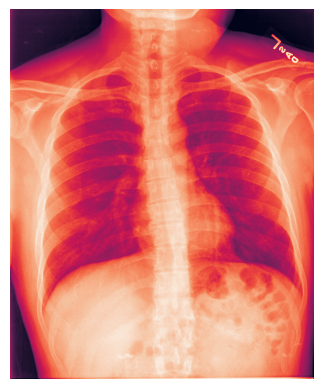

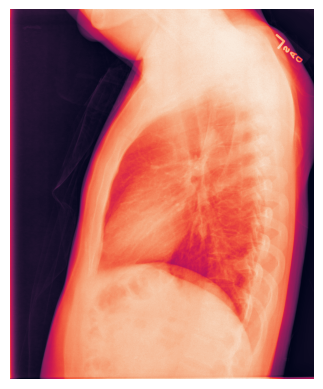


Comparision : None

Indication : chest pain

Findings : heart size normal lungs are clear are normal no pneumonia effusions edema pneumothorax adenopathy nodules or masses

Impression : normal chest

Caption : chest radiograph frontal and lateral from at hours


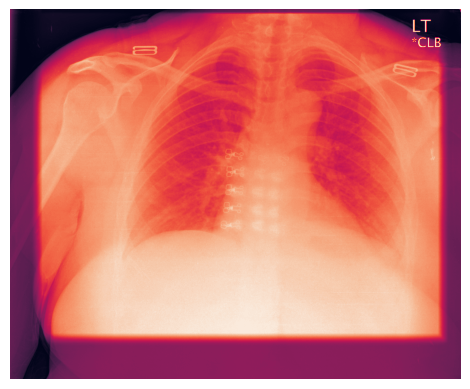


Comparision : None

Indication : dyspnea

Findings : the cardiac silhouette and mediastinal contours are within normal limits there are low lung volumes with bronchovascular crowding otherwise the lungs are clear there is no pneumothorax no large pleural effusion

Impression : low lung volumes with bronchovascular crowding otherwise lungs are clear



In [31]:
#showing sample 2 datapoints
show_image_captions(df, 2)

In [32]:
k = df.loc[(df.comparison == 'none') | (df.comparison == 'no comparison')]
print("Number of rows with no informnation in comparision label:",k.shape[0])

Number of rows with no informnation in comparision label: 1406


In [33]:
def unique_words_features(df):
    # '''This function takes pandas dataframe and show barplot of features unique and repeated words 
    #    Input  =  pandas dataframe or numpy arrays
    #    Output =  barplot of the unique words of dataframe '''

    #length of the feature
    len_total = len(df.tolist())

    #length of unique words in the featue
    len_unique = len(np.unique(df.tolist()))

    x = ['Total Values', 'Unique Values']
    y =  [len_total, len_unique]

    plt.bar(x,y,color = 'Teal')
    plt.ylabel('Word-Count')
    for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
    
    plt.ylabel('Word-Count')
    


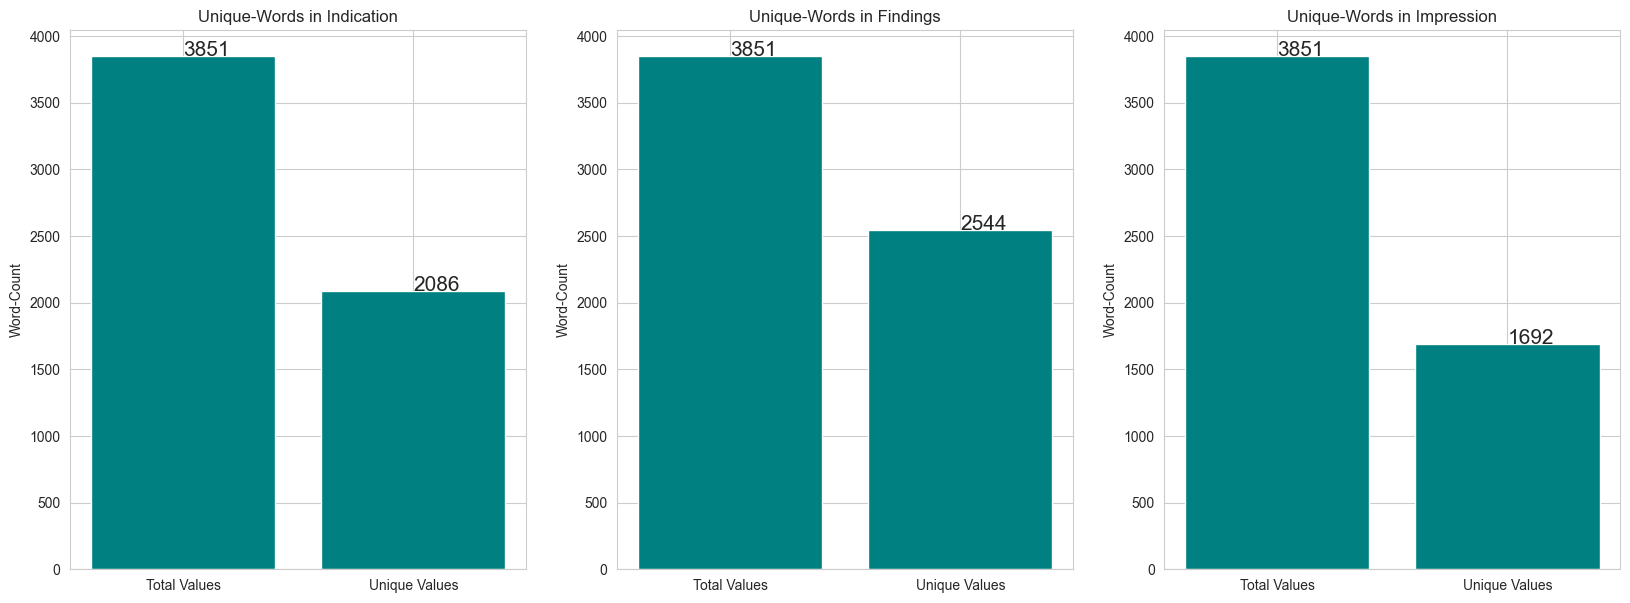

In [34]:
plt.figure(figsize = (20,7))
plt.subplot(131)
unique_words_features(df['indication'])
plt.title('Unique-Words in Indication')
plt.subplot(132)
unique_words_features(df['findings'])
plt.title('Unique-Words in Findings')
plt.subplot(133)
unique_words_features(df['impression'])
plt.title('Unique-Words in Impression')
plt.show()

In [35]:
#Printing min,max and median of word_count
print("Minimum number of word count for Indication is:",np.min(df.indication_count.values))
print("Maximum number of word count for Indication is:",np.max(df.indication_count.values))
print("median number of word count for Indication is:",np.median(df.indication_count.values))

Minimum number of word count for Indication is: 1
Maximum number of word count for Indication is: 32
median number of word count for Indication is: 3.0


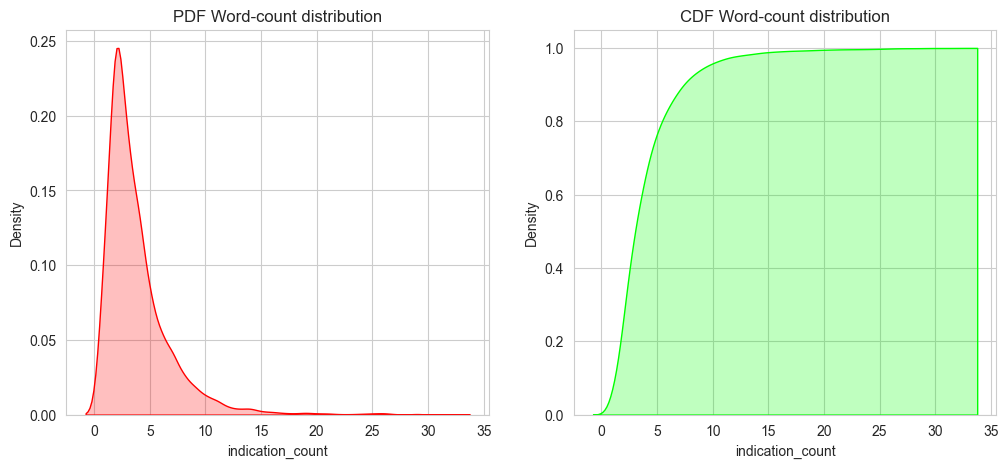

In [36]:
#Plotting PDF and CDF for word_count distribution of Indication feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(df['indication_count'],shade=True,color='Red')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(df['indication_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

In [37]:
df.head()

image_name   
0      1_IM-0001-3001.dcm.png,1_IM-0001-4001.dcm.png  \
1    10_IM-0002-1001.dcm.png,10_IM-0002-2001.dcm.png   
2  100_IM-0002-1001.dcm.png,100_IM-0002-2001.dcm.png   
3  1000_IM-0003-1001.dcm.png,1000_IM-0003-2001.dc...   
4  1001_IM-0004-1001.dcm.png,1001_IM-0004-1002.dc...   

              image_caption                        comparison   
0  ray chest pa and lateral                              none  \
1    pa and lateral chest x                 chest radiographs   
2  chest frontal lateral pm                              none   
3    pa and lateral chest x  pa and lateral chest radiographs   
4  chest frontal lateral pm                              none   

                                          indication   
0                                   positive tb test  \
1                                    male chest pain   
2                                      No Indication   
3                                               male   
4  dyspnea subjective fevers arthritis immigrant ...   

                                            findings   
0  the cardiac silhouette and mediastinum size ar...  \
1  the cardiomediastinal silhouette is within nor...   
2  both lungs are clear and expanded heart and me...   
3  there is increased opacity within the right up...   
4  interstitial markings are diffusely prominent ...   

                                          impression  image_count   
0                                     normal chest x            2  \
1                   no acute cardiopulmonary process            2   
2                                  no active disease            2   
3  increased opacity in the right upper lobe with...            3   
4    diffuse fibrosis no visible focal acute disease            2   

   indication_count  findings_count  impression_count  
0                 3              33                 3  
1                 3              38                 4  
2                 2              10                 3  
3                 1              52                36  
4                 7              14                 7

In [38]:
df.head()

image_name   
0      1_IM-0001-3001.dcm.png,1_IM-0001-4001.dcm.png  \
1    10_IM-0002-1001.dcm.png,10_IM-0002-2001.dcm.png   
2  100_IM-0002-1001.dcm.png,100_IM-0002-2001.dcm.png   
3  1000_IM-0003-1001.dcm.png,1000_IM-0003-2001.dc...   
4  1001_IM-0004-1001.dcm.png,1001_IM-0004-1002.dc...   

              image_caption                        comparison   
0  ray chest pa and lateral                              none  \
1    pa and lateral chest x                 chest radiographs   
2  chest frontal lateral pm                              none   
3    pa and lateral chest x  pa and lateral chest radiographs   
4  chest frontal lateral pm                              none   

                                          indication   
0                                   positive tb test  \
1                                    male chest pain   
2                                      No Indication   
3                                               male   
4  dyspnea subjective fevers arthritis immigrant ...   

                                            findings   
0  the cardiac silhouette and mediastinum size ar...  \
1  the cardiomediastinal silhouette is within nor...   
2  both lungs are clear and expanded heart and me...   
3  there is increased opacity within the right up...   
4  interstitial markings are diffusely prominent ...   

                                          impression  image_count   
0                                     normal chest x            2  \
1                   no acute cardiopulmonary process            2   
2                                  no active disease            2   
3  increased opacity in the right upper lobe with...            3   
4    diffuse fibrosis no visible focal acute disease            2   

   indication_count  findings_count  impression_count  
0                 3              33                 3  
1                 3              38                 4  
2                 2              10                 3  
3                 1              52                36  
4                 7              14                 7

In [39]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(df['indication'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

In [40]:
#Plotting top 50 frequent sentences of Findings feature
sentences = df['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(x=sentences.index, y=sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Findings-Unique sentences")
plt.show()

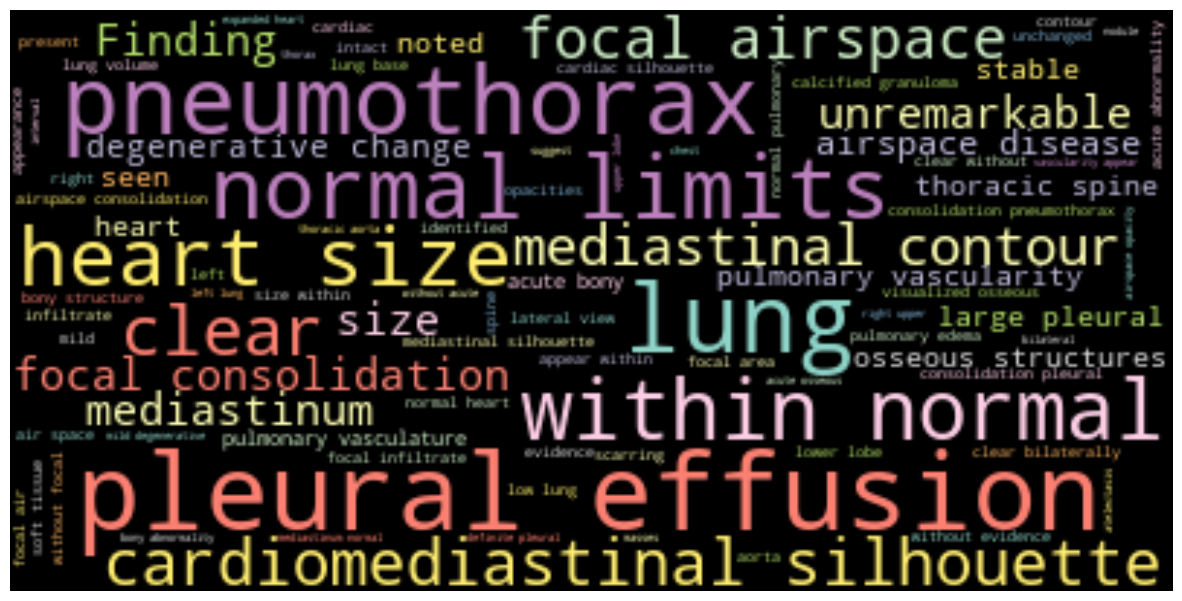

In [41]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(df['findings'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

In [42]:
df.isnull().sum()

#checking how many of the reports have infection or pneumonia

#checking how many of the reports have infection or pneumonia

def check_infection_pneumonia(df):
    """
    This function checks if the reports have infection or pneumonia
    """
    infection = df[df['findings'].str.contains('infiltrate|infiltrates|infiltration|infiltrations|infection|infections|pneumonia|pneumonias', case=False, na=False)]
    return infection


In [43]:
pnemonia_patients=check_infection_pneumonia(df)

print("Number of reports with infection or pneumonia:",pnemonia_patients.shape[0])

Number of reports with infection or pneumonia: 459


In [44]:
def show_image(path):
    """
    This function takes the path of the image and displays it
    """
    img = Image.open(path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

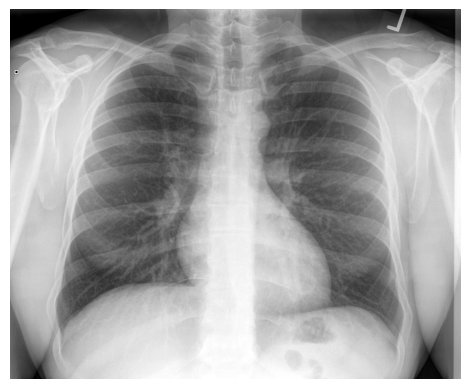

In [45]:
# loop through df and display each row

for index, row in df.iterrows():
    if ',' in row['image_name']:
        for img in img_name.split(','):
            img_path = os.path.join("./data/images/images_normalized/", img)
            show_image(img_path)
    else:
        img_name = row['image_name']
    
    if index==0:
        break
   

In [56]:
images_path="./data/images/images_normalized/"



# Create a list to store the transformed tensors
image_tensors = []

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert image to RGB format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Iterate over the PNG images in the directory
for filename in os.listdir(images_path):
    if filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(images_path, filename)
        image = Image.open(image_path)
        
        # Apply the transformation pipeline
        transformed_image = transform(image)
        
        # Append the transformed tensor to the list
        image_tensors.append(transformed_image)

# Convert the list of tensors to a PyTorch tensor
image_tensor = torch.stack(image_tensors)

# Print the shape of the tensor
print("Shape of the image tensor:", image_tensor.shape)



Shape of the image tensor: torch.Size([7470, 3, 224, 224])


In [57]:
image_tensor[0].shape
image_tensor.ndim

4

In [58]:
# Using Resnet in pytorch to extract features from the images and get the feature vector of the images 
# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

# Remove the classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Set the model to evaluation mode
resnet.eval()

# Create a list to store the feature vectors
feature_vectors = []

# Iterate over the images in the image_tensor
for image in image_tensor:
    # Unsqueeze the image to add a batch dimension
    transformed_image = image.unsqueeze(0)
    
    # Pass the image through the model
    output = resnet(transformed_image)
    
    # Squeeze the output to remove the batch dimension
    feature_vector = output.squeeze(0)
    
    # Append the feature vector to the list
    feature_vectors.append(feature_vector.detach().numpy())


    

In [59]:
#print the shape of the feature vector
print("Shape of the feature vector:", feature_vectors[0].shape)

Shape of the feature vector: (512, 1, 1)
